## What are Custom Datasets?

`Custom Datasets` are Datasets that are _created_ either from us, or third parties and we want to create a Deep Learning Model, in Pytorch, that takes as _input_ samples from that Dataset and generating some ouputs.

For that reason, Pytorch provide us with `torchvision`, `torchtext`, `torchaudio` and `torchrec`, for _computer vision_, _text_ and _audio_ models and also for _recommendation systems_.

## Importing the Modules

In [ ]:
import torch
from torch import nn
from torch import optim as opt
from torch.utils.data import DataLoader
from torchvision import transforms           # For creating the `transforms` so we prepare the Dataset
from torchvision.datasets import ImageFolder # Helping Function for converting the Images Dataset into a Pytorch Dataset
from torchvision.io import read_image        # For reading an unseen data and converting into Pytorch format     

import numpy as np              # For visualize an image (passing it through `matplotlib`)
import matplotlib.pyplot as plt

import os             # For understanding the Dataset (walk through the Dataset)
from PIL import Image # For visualize an image

from timeit  import default_timer as timer
from tqdm.auto import tqdm

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary # For a summary of the input and output shape of a Model

## Setting Default Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


## Downloading the Dataset

The Dataset will be a subset of the `Food101` Dataset.

The reason we are doing that is to start and experiment on smaller datasets to speed up the experements and the hole process. Then after we are done we are scaling and start performing other experiments.

This Dataset complies with the `Standard Image Classification Data Format` that simply tells us that:
* First we have the Dataset Folder.
* Then Training and a Testing Folder (and Validating Folder if we want).
* Inside training and testing folders we have Folders for each Class in which are all the images that are labeled that Class.

In [ ]:
import requests            # For geting the Dataset from `github`
import zipfile             # The Dataset is going to be a `zip` file
from pathlib import Path   # For saving the Dataset
from os import remove      # For deleting the `zip` file


# Setting the path in which the Dataset is going to be saved
data_path = Path("/data")
dataset_path = data_path / "pizza_steak_sushi"

# If the Dataset folder does not exists we want to create it
if dataset_path.is_dir():
    print(f"{dataset_path} already exists...")
else:
    print(f"{dataset_path} doesn't exists... Creating it...")

    dataset_path.mkdir(parents=True, exist_ok=True) # Create the directory

# Downloading the Dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    # Getting the Dataset from `github` (right click on `download` and `copy link address`)
    req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")

    print("Downloading the Dataset...")

    f.write(req.content) # Writting the Dataset to Path

# Unzipping the Dataset from Path
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping Dataset...")
    
    zip_ref.extractall(dataset_path) # Extracting the `zip` to 'dataset_path'

# Deletting the `zip` file
remove(data_path / "pizza_steak_sushi.zip")

print(f"Dataset Succesfully Downloaded in {dataset_path}")

/data/pizza_steak_sushi already exists...
Unzipping Dataset...
Dataset Succesfully Downloaded in /data/pizza_steak_sushi


## Creating a Function to Get the Content of a Folder

In [ ]:
def walk_through_dir(dir_path):

    for dir_path, dir_names, file_names in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories and {len(file_names)} in {dir_path}")

### Checking this Function

In [ ]:
walk_through_dir(dataset_path)

There are 2 directories and 0 in /data/pizza_steak_sushi
There are 3 directories and 0 in /data/pizza_steak_sushi/train
There are 0 directories and 78 in /data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 in /data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 in /data/pizza_steak_sushi/train/steak
There are 3 directories and 0 in /data/pizza_steak_sushi/test
There are 0 directories and 25 in /data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 in /data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 in /data/pizza_steak_sushi/test/steak


## Setting the Training and the Testing Paths

In [ ]:
train_path = dataset_path / "train"
test_path = dataset_path / "test"

print(train_path)
print(test_path)

/data/pizza_steak_sushi/train
/data/pizza_steak_sushi/test


In [ ]:
walk_through_dir(train_path)

There are 3 directories and 0 in /data/pizza_steak_sushi/train
There are 0 directories and 78 in /data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 in /data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 in /data/pizza_steak_sushi/train/steak


## Visualizing Images

### Using Pillow

In [ ]:
# Get the list of all files (images) in the Dataset
dataset_images = list(dataset_path.glob("*/*/*.jpg")) # With 'glob()' we are getting each subdir that matches the parameters format

image = dataset_images[0] # Getting a image form the Dataset

print(image, len(dataset_images))

/data/pizza_steak_sushi/train/pizza/2687575.jpg 300


In [ ]:
# Getting the Class of that image
image_class = image.parent.stem 

# With 'image.parent' we are getting the parent path of the image
# And with 'stem' the last component of that path, meaning the name of the parent class

print(image_class)

pizza


Image Path: /data/pizza_steak_sushi/train/pizza/2687575.jpg
Image Height: 384
Image Width: 512



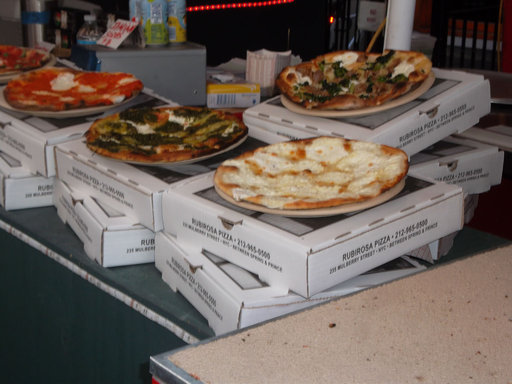

In [ ]:
# Visualize the image

with Image.open(image) as img:
    print(f"Image Path: {image}")
    print(f"Image Height: {img.height}")
    print(f"Image Width: {img.width}", end='\n\n')
    img.show()

### Using Matplotlib

(512, 508, 3)



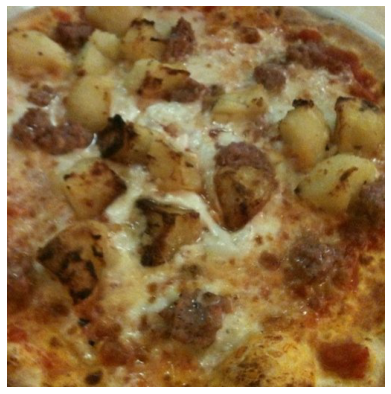

In [ ]:
# Convert the image into an array
with Image.open(dataset_images[3]) as img:
    image_arr = np.asarray(img)

    print(image_arr.shape, end="\n\n") # shape: (Height, Width, Colour Channels)

    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis(False)

## Converting the Dataset into Tensors Format

In [ ]:
# We see that the images from the Datasets does not have the same size: (Heigth, Width)

# Creating a `Transform` object to prepare the Dataset (as parameter it gets a List)
dataset_transforms = transforms.Compose([
    # Resizing each image:
    transforms.Resize(size=(64, 64)),

    # Flipping random images horizontaly (for complex pattern finder)
    transforms.RandomHorizontalFlip(p=0.5), # with 0.5 probability

    # Converting each image to a Tensor
    transforms.ToTensor() # Changes the shape to (Colour Channels, Heidth, Width) and each pixel value to [0.0, 1.0]
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

torch.Size([3, 64, 64])
tensor([0.2745, 0.2902, 0.2196, 0.2275, 0.4039])



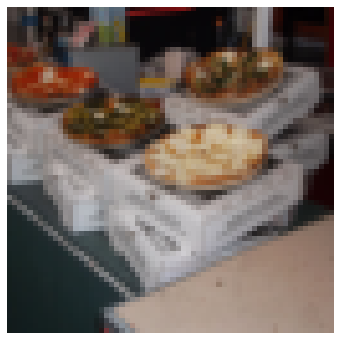

In [ ]:
# Passing an image through that Transformation
with Image.open(dataset_images[0]) as img:
    transformed_image = dataset_transforms(img)

    print(transformed_image.shape)
    print(transformed_image[0][0][:5], end="\n\n")

    # Plotting that image:
    plt.figure(figsize=(6, 6))
    plt.imshow(transformed_image.permute(1, 2, 0)) # Matplotlib needs the `Colour Channels` at the end
    plt.axis(False)

torch.Size([3, 64, 64])
tensor([0.6863, 0.6824, 0.6902, 0.6941, 0.6196])



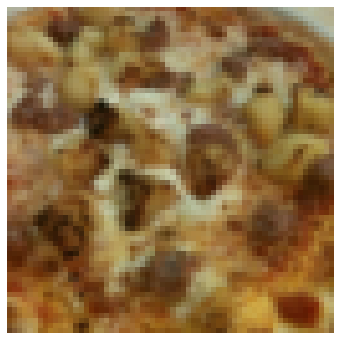

In [ ]:
# And for the other image
with Image.open(dataset_images[3]) as img:
    transformed_image = dataset_transforms(img)

    print(transformed_image.shape)
    print(transformed_image[0][0][:5], end="\n\n")

    # Plotting that image:
    plt.figure(figsize=(6, 6))
    plt.imshow(transformed_image.permute(1, 2, 0))
    plt.axis(False)

In [ ]:
# Creating a Function that plots an image prior and after the tranformation
def plot_before_and_after(image_path_list, transforms):
    for image_path in image_path_list:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(nrows=1, ncols=2)

            ax[0].imshow(img)
            ax[0].set_title(f"Original Shape:\n({img.size[0]}, {img.size[1]}, 3)")
            ax[0].axis(False)

            transformed_img = transforms(img)
            ax[1].imshow(transformed_img.permute(1, 2, 0))
            ax[1].set_title(f"Transformed Shape:\n({transformed_img.size(dim=0)}, {transformed_img.size(dim=1)}, {transformed_img.size(dim=2)})")
            ax[1].axis(False)

            fig.subplots_adjust(bottom=0.05)
            fig.subplots_adjust(top=0.9)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

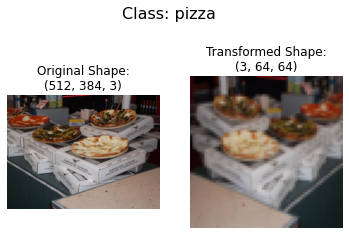

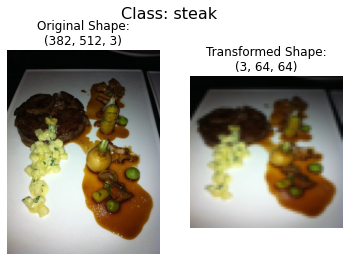

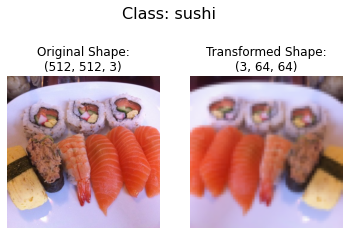

In [ ]:
# Plotting some Transformations
plot_before_and_after([dataset_images[0], dataset_images[150], dataset_images[250]], dataset_transforms)

## Loading Images to Create a Pytorch Dataset

### Using `ImageFolder`.

In [ ]:
# Creating the Training and Testing Pytorch Datasets (works with `Standard Image Classification Data Format`)
train_ds = ImageFolder(root=train_path, transform=dataset_transforms)
test_ds = ImageFolder(root=test_path, transform=test_transforms)

print(train_ds)
print(test_ds)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: /data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: /data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
# Using a Pytorch Dataset we can easizly access the labels names:
label_names = train_ds.classes

# We can get the labels names as a Dictionariy
label_name_dict = train_ds.class_to_idx

print(label_names)
print(label_name_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [ ]:
# Now the Image Dataset has been fully translated into Pytorch language
first_sample = train_ds[0]

first_image, first_label = first_sample

print(first_image.shape)
print(first_image.dtype)
print(first_image[0][0][:5])
print(first_label)

torch.Size([3, 64, 64])
torch.float32
tensor([0.1176, 0.1216, 0.1255, 0.1216, 0.1216])
0


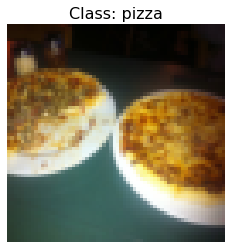

In [ ]:
# Plotting the Image
plt.imshow(first_image.permute(1, 2, 0))
plt.title(f"Class: {label_names[first_label]}", fontsize=16)
plt.axis(False);

### Without Using `Helping Functions`.

The main reason for creating our own Dataset Classes is that we can create a Dataset for almost enerything.

In [ ]:
# We will follow the Direction of 'torch.utils.data.Dataset'
class CustomImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.paths = list(root.glob("*/*.jpg"))
        self.transform = transform
        self.classes = [entry.name for entry in list(os.scandir(root))]
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def load_image(self, index):
        if (index >= 0) and (index < len(self.paths)):
            return Image.open(self.paths[index])
        raise IndexError

    def __getitem__(self, index):
            return (self.transform(self.load_image(index)), self.class_to_idx[self.paths[index].parent.stem])

    def __len__(self):
        return len(self.paths)


train_dataset = CustomImageFolder(train_path, dataset_transforms)

In [ ]:
# Printing the classes
print(train_dataset.classes)
print(train_dataset.class_to_idx)

['pizza', 'sushi', 'steak']
{'pizza': 0, 'sushi': 1, 'steak': 2}


In [ ]:
# Seeing the first element of the Dataset
first_image, first_label = train_dataset[0]

print(first_image.shape)
print(first_image.dtype)
print(first_image[0][0][:5])
print(first_label)

torch.Size([3, 64, 64])
torch.float32
tensor([0.2745, 0.2902, 0.2196, 0.2275, 0.4039])
0


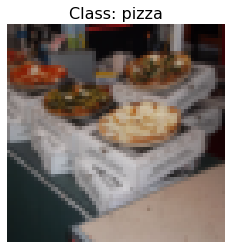

In [ ]:
# Plotting the Image
plt.imshow(first_image.permute(1, 2, 0))
plt.title(f"Class: {label_names[first_label]}", fontsize=16)
plt.axis(False);

## Creating the Custom Dataset Objects

In [ ]:
train_ds = CustomImageFolder(root=train_path, transform=dataset_transforms)
test_ds = CustomImageFolder(root=test_path, transform=test_transforms)

print(len(train_ds), len(test_ds))

225 75


In [ ]:
# Now the Image Dataset has been fully translated into Pytorch language
first_sample = train_ds[0]

first_image, first_label = first_sample

print(first_image.shape)
print(first_image.dtype)
print(first_image[0][0][:5])
print(first_label)

torch.Size([3, 64, 64])
torch.float32
tensor([0.2745, 0.2902, 0.2196, 0.2275, 0.4039])
0


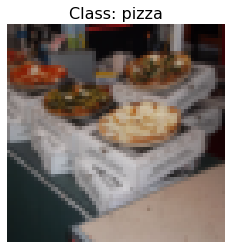

In [ ]:
# Plotting the Image
plt.imshow(first_image.permute(1, 2, 0))
plt.title(f"Class: {label_names[first_label]}", fontsize=16)
plt.axis(False);

## Splitting the Training and Testing Dataset into Batches

In [ ]:
BATCH_SIZE = 16

train_dl = DataLoader(dataset=train_ds,
                      batch_size=BATCH_SIZE,
                      num_workers=os.cpu_count(), # The number of cores to use ('cpu_count()' returns the number of cores available)
                      shuffle=True)
test_dl = DataLoader(dataset=test_ds,
                     batch_size=BATCH_SIZE,
                     num_workers=os.cpu_count())

print(len(train_dl), len(test_dl))

15 5


In [ ]:
# Getting the first batch
images, labels = next(iter(train_dl))

print(images.shape)
print(labels)

torch.Size([16, 3, 64, 64])
tensor([0, 2, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 2])


## Data Augmentation 

Data Augmentation is a technique that is used to increase the number of samples in a Dataset by adding to it slightly **modified copies** of existing samples.

Using Data Augmentation we are adding **diversiry** to our Training Data.

This helps the **Neural Network** to generalize the _patterns_ that is learns.

There are a lot of ways to `Augment` a Dataset, we are going to look at `Trivial Augment`.

In [ ]:
# Creating the Transformation that usese `trivialagument`

train_transform_da = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # A very common size for image recognition
    transforms.TrivialAugmentWide(num_magnitude_bins=32), # A number that gives us the maximum intensity of the augmentate
    transforms.ToTensor()
])

test_transform_da = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

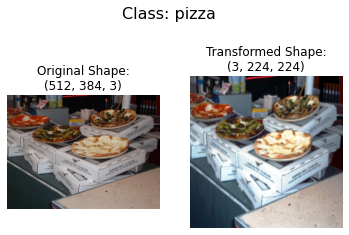

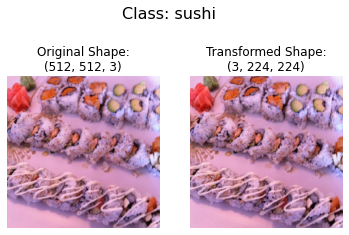

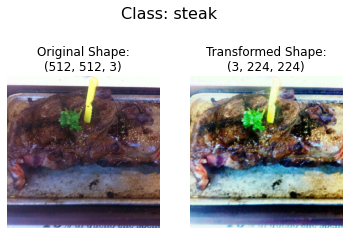

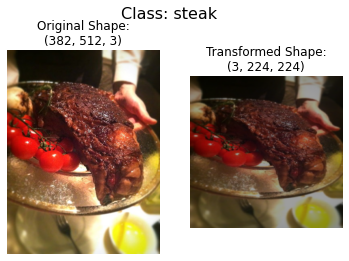

In [ ]:
# Understanding the Transformation by plotting some images
dataset_images = list(dataset_path.glob("*/*/*.jpg"))

plot_before_and_after([dataset_images[0], dataset_images[100], dataset_images[200], dataset_images[299]], train_transform_da)

## Creating the Custom Pytorch Dataset and Data Loaders (for Data Augmentation)

In [ ]:
train_ds_da = CustomImageFolder(root=train_path, transform=train_transform_da)
test_ds_da = CustomImageFolder(root=test_path, transform=test_transform_da)

BATCH_SIZE = 16

train_dl_da = DataLoader(dataset=train_ds_da,
                      batch_size=BATCH_SIZE,
                      num_workers=os.cpu_count(),
                      shuffle=True)
test_dl_da = DataLoader(dataset=test_ds_da,
                     batch_size=BATCH_SIZE,
                     num_workers=os.cpu_count())

## Creating the Custom Pytorch Dataset and Data Loaders (no Data Augmentation)

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_ds_simple = CustomImageFolder(root=train_path, transform=simple_transform)
test_ds_simple = CustomImageFolder(root=test_path, transform=simple_transform)

BATCH_SIZE = 16

train_dl_simple = DataLoader(dataset=train_ds_simple,
                      batch_size=BATCH_SIZE,
                      num_workers=os.cpu_count(),
                      shuffle=True)
test_dl_simple = DataLoader(dataset=test_ds_simple,
                     batch_size=BATCH_SIZE,
                     num_workers=os.cpu_count())

## Creating Baseline Model (without Data Augmentation)

In [ ]:
class Food_ModelV0(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=2) # The default stride is the same as the kernel size
        ) # Output: (`batch_size`, `hidde_units`, 30, 30)

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        ) # Output: (`batch_size`, `hidde_units`, 13, 13)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=output_size),
        ) # Output: (`batch_size`, `output_size`)

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

## Initizlizing the Model and Passing Data through it

In [ ]:
modelv0 = Food_ModelV0(3, 10, 3).to(device)

print(modelv0)

Food_ModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)


first sample label: steak


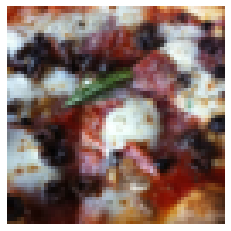

In [ ]:
# Generating logits
modelv0.eval()
with torch.inference_mode():
    x, y = next(iter(test_dl_simple))
    first_sample_img = x[0]
    logits = modelv0(x.to(device))

# Converting logits into labels
first_sample_logits = logits[0]
first_sample_preds = torch.softmax(first_sample_logits, dim=0)
first_sample_label = first_sample_preds.argmax(dim=0).item()
print(f"first sample label: {label_names[first_sample_label]}")

# Plotting the Image
plt.imshow(first_sample_img.permute(1, 2, 0))
plt.axis(False);

In [ ]:
# Using `torchinfo` to get information about the model
summary(modelv0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Food_ModelV0                             [16, 3]                   --
├─Sequential: 1-1                        [16, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [16, 10, 62, 62]          280
│    └─ReLU: 2-2                         [16, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [16, 10, 60, 60]          910
│    └─ReLU: 2-4                         [16, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [16, 10, 30, 30]          --
├─Sequential: 1-2                        [16, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [16, 10, 28, 28]          910
│    └─ReLU: 2-7                         [16, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [16, 10, 26, 26]          910
│    └─ReLU: 2-9                         [16, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [16, 10, 13, 13]          --
├─Sequentia

## Creating Training and Evaluating Loop

In [ ]:
def fit(model, epochs, train_dl, test_dl, loss_fn, eval_fn, optim, print_every_epoch=1, print_total_batches=None):
    start_time = timer()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    model_device = torch.device("cuda" if next(model.parameters()).device.type == "cuda" else "cpu")

    print("Starting Process...")

    for epoch in tqdm(range(1, epochs + 1)):
        
        # 1. Training Step
        train_loss, train_acc = 0, 0
        
        model.train()
        for batch_num, (x_train, y_train) in enumerate(train_dl, start=1):
            # Moving bathces to device
            x_train, y_train = x_train.to(model_device), y_train.to(model_device)

            train_logits = model(x_train)
            loss = loss_fn(train_logits, y_train)

            train_loss += loss.item()
            train_acc += eval_fn(train_logits, y_train)

            optim.zero_grad()
            loss.backward()
            optim.step()

            if print_total_batches and (batch_num % (len(train_dl) // print_total_batches) == 0):
                print(f"\tLooked at {batch_num*len(x_train)}/{len(train_dl)*len(x_train)} training samples...")

        train_loss /= len(train_dl)
        train_acc /= len(train_dl)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 2. Validation Step
        test_loss, test_acc = 0, 0

        model.eval()
        with torch.inference_mode():
            for x_test, y_test in test_dl:
                # Moving batches to device
                x_test, y_test = x_test.to(model_device), y_test.to(model_device)

                test_logits = model(x_test)
                test_loss += loss_fn(test_logits, y_test).item()
                test_acc += eval_fn(test_logits, y_test)

            test_loss /= len(test_dl)
            test_acc /= len(test_dl)

            test_losses.append(test_loss)
            test_accs.append(test_acc)

        if (print_every_epoch > 0) and (epoch % print_every_epoch == 0):
            print(f"-> Epoch: {epoch} | " +
                    f"Train Loss: {train_loss:.4f} | " +
                    f"Train Accuracy: {train_acc:.3f}% | " +
                    f"Test Loss: {test_loss:.4f} | " +
                    f"Test Accuracy: {test_acc:.3f}%")

    return {"model_train_loss": train_losses,
            "model_train_acc": train_accs,
            "model_test_loss": test_losses,
            "model_test_acc": test_accs,
            "model_name": model.__class__.__name__,
            "model_loss_fn": loss_fn.__class__.__name__,
            "model_optimizer": optim.__class__.__name__,
            "model_evaluating_m": eval_fn.__name__,
            "model_device": next(model.parameters()).device.type,
            "model_epochs": epochs,
            "model_time": timer() - start_time}

## Setting Loss Function and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = opt.Adam(params=modelv0.parameters(), lr=1e-3)

## Setting an Accuracy Metric

In [ ]:
def accuracy_fn(model_logits, labels):
    model_labels = torch.softmax(model_logits.type(torch.float32), dim=1).argmax(dim=1)
    return (torch.sum(model_labels == labels).item() / len(labels)) * 100

## Training the Model

In [ ]:
res_0 = fit(modelv0, 15, train_dl_simple, test_dl_simple, loss_fn, accuracy_fn, optim, 2)

Starting Process...


  0%|          | 0/15 [00:00<?, ?it/s]

-> Epoch: 2 | Train Loss: 1.0953 | Train Accuracy: 39.583% | Test Loss: 1.0950 | Test Accuracy: 38.523%
-> Epoch: 4 | Train Loss: 1.0533 | Train Accuracy: 58.333% | Test Loss: 1.0616 | Test Accuracy: 44.432%
-> Epoch: 6 | Train Loss: 0.9751 | Train Accuracy: 54.583% | Test Loss: 0.9980 | Test Accuracy: 40.909%
-> Epoch: 8 | Train Loss: 0.8741 | Train Accuracy: 54.583% | Test Loss: 1.0211 | Test Accuracy: 42.273%
-> Epoch: 10 | Train Loss: 0.8762 | Train Accuracy: 54.167% | Test Loss: 0.9721 | Test Accuracy: 49.659%
-> Epoch: 12 | Train Loss: 0.7736 | Train Accuracy: 68.750% | Test Loss: 1.0190 | Test Accuracy: 44.091%
-> Epoch: 14 | Train Loss: 0.8305 | Train Accuracy: 65.833% | Test Loss: 1.0590 | Test Accuracy: 44.659%


## Printing the Results

In [ ]:
print(res_0)

{'model_train_loss': [1.1109263102213542, 1.0952605485916138, 1.0746877710024516, 1.0533285776774088, 0.9844169775644939, 0.9751414736111959, 0.8654810746510824, 0.8741414944330851, 0.8040959899624188, 0.8762442986170451, 0.7548290252685547, 0.7736013809839885, 0.7422690649827322, 0.8304559667905171, 0.7454012597600619], 'model_train_acc': [29.166666666666668, 39.583333333333336, 52.5, 58.333333333333336, 60.416666666666664, 54.583333333333336, 64.58333333333333, 54.583333333333336, 60.0, 54.166666666666664, 67.5, 68.75, 68.33333333333333, 65.83333333333333, 70.0], 'model_test_loss': [1.0987783193588256, 1.0949824094772338, 1.0843639373779297, 1.0615569472312927, 1.0331079006195067, 0.9979875445365906, 0.9813599705696106, 1.0211271524429322, 1.1000967144966125, 0.9720577001571655, 1.0061787009239196, 1.0189871788024902, 1.0548964023590088, 1.0589601397514343, 0.9781000852584839], 'model_test_acc': [34.54545454545455, 38.52272727272727, 43.75, 44.43181818181818, 35.340909090909086, 40.9

## Plotting the Loss Curve of the Model

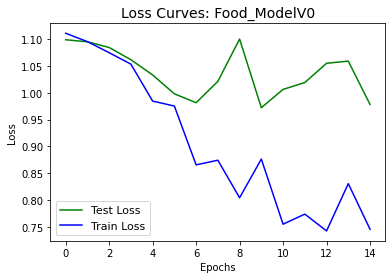

In [ ]:
def plot_loss_curve(model_res):
    plt.figure(figsize=(6, 4))
    
    plt.plot(range(model_res["model_epochs"]), model_res["model_test_loss"], c='g', label="Test Loss")
    plt.plot(range(model_res["model_epochs"]), model_res["model_train_loss"], c='b', label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves: {model_res['model_name']}", fontsize=14)
    plt.legend(fontsize=11)

plot_loss_curve(res_0)

## Plotting the Accuracy Curves of the Model

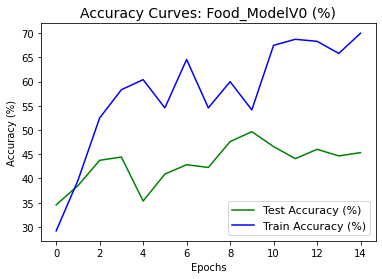

In [ ]:
def plot_acc_curve(model_res):
    plt.figure(figsize=(6, 4))
    
    plt.plot(range(model_res["model_epochs"]), model_res["model_test_acc"], c='g', label="Test Accuracy (%)")
    plt.plot(range(model_res["model_epochs"]), model_res["model_train_acc"], c='b', label="Train Accuracy (%)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curves: {model_res['model_name']} (%)", fontsize=14)
    plt.legend(fontsize=11)

plot_acc_curve(res_0)

## Interpreting a Loss Curve

The loss curve is one of the mode helpfull ways to troubleshoot a model.

We have 2 Loss Curves Categories:
1. `Underfitting`: Both the Training and Testing loss curves could be low (note that training loss should be lower that testing). To deal with **Underfitting** we can:
    * Create a more Complex Moder
    * Tweak the Learning Rate (might be too hight for it to learn)
    * Increase the number of Epochs
2. `Overfitting`: The Training loss curve is lower that the Testing curve and the Training curve keep decreasing but the Testing curve stays put. That means that the _learning_ of the model is not reflecting into the Training Samples. To deal with **Overfitting** we can:
    * Get more (and better) Data
    * Use Data Augmentation
    * Simplify the Model (because it is learning the patters too well)
    * Use Learning Rate Decay
    * Use Early Stopping (when the difference of the curves passes a threshold)

By trying to deal with one of those problems we are inceasing the probability that the other problem will occur. So we have to find the fine-tuning to solves both of those problems.

`Transfer Learing` can help us deal with both of those problems.

The ideal `Loss Curves` includes both the Training and the Testing curves to behave like the 1/x function and be as close as possible.

## Creating Custom Pytorch Dataset and Data Loader (using Data Augmentation)

In [ ]:
# Creating the training dataset transformation
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

train_ds = CustomImageFolder(root=train_path, transform=train_transforms)
test_ds = CustomImageFolder(root=test_path, transform=simple_transform)

BATCH_SIZE = 16

train_dl = DataLoader(dataset=train_ds,
                      batch_size=BATCH_SIZE,
                      num_workers=os.cpu_count(),
                      shuffle=True)
test_dl = DataLoader(dataset=test_ds,
                     batch_size=BATCH_SIZE,
                     num_workers=os.cpu_count())

## Using the same Model with Data Augmentation

In [ ]:
modelv1 = Food_ModelV0(3, 10, 3).to(device)

print(modelv1)

Food_ModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)


## Setting Loss Function and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = opt.Adam(params=modelv1.parameters(), lr=1e-3)

## Training the Model of the new Data Loaders

In [ ]:
res_1 = fit(modelv1, 15, train_dl, test_dl, loss_fn, accuracy_fn, optim, 2)

Starting Process...


  0%|          | 0/15 [00:00<?, ?it/s]

-> Epoch: 2 | Train Loss: 1.0921 | Train Accuracy: 38.750% | Test Loss: 1.1026 | Test Accuracy: 31.250%
-> Epoch: 4 | Train Loss: 1.0985 | Train Accuracy: 32.500% | Test Loss: 1.0855 | Test Accuracy: 37.386%
-> Epoch: 6 | Train Loss: 1.0409 | Train Accuracy: 47.500% | Test Loss: 1.0068 | Test Accuracy: 42.727%
-> Epoch: 8 | Train Loss: 0.9461 | Train Accuracy: 52.500% | Test Loss: 0.9979 | Test Accuracy: 44.773%
-> Epoch: 10 | Train Loss: 0.9864 | Train Accuracy: 47.917% | Test Loss: 0.9452 | Test Accuracy: 47.841%
-> Epoch: 12 | Train Loss: 1.0704 | Train Accuracy: 48.750% | Test Loss: 0.9803 | Test Accuracy: 41.023%
-> Epoch: 14 | Train Loss: 0.9506 | Train Accuracy: 56.250% | Test Loss: 0.9591 | Test Accuracy: 44.091%


We can see that the Model is failing of immitating the training data. Data Augmentation works!

## Printing Results

In [ ]:
print(res_1)

{'model_train_loss': [1.107690397898356, 1.092089343070984, 1.0913860638936361, 1.0985063393910726, 1.0719170490900676, 1.040921417872111, 0.968882817029953, 0.9460692465305328, 0.9950991034507751, 0.9864449739456177, 0.9494424819946289, 1.070376984278361, 0.9473609844843547, 0.9506486177444458, 0.9089987476666769], 'model_train_acc': [35.0, 38.75, 38.75, 32.5, 45.416666666666664, 47.5, 54.166666666666664, 52.5, 57.5, 47.916666666666664, 55.0, 48.75, 55.416666666666664, 56.25, 57.083333333333336], 'model_test_loss': [1.101595664024353, 1.1025777339935303, 1.1012060642242432, 1.0855242133140564, 1.0342272758483886, 1.0068169832229614, 0.9834980130195617, 0.9978978514671326, 0.9815792560577392, 0.9451756834983825, 0.9543553113937377, 0.9802674293518067, 0.9753639578819275, 0.9590906143188477, 0.9521910309791565], 'model_test_acc': [31.25, 31.25, 31.25, 37.38636363636364, 43.40909090909091, 42.72727272727273, 42.72727272727273, 44.77272727272727, 46.02272727272727, 47.840909090909086, 42.

## Plotting Loss Curves

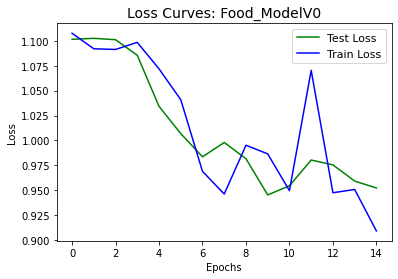

In [ ]:
plot_loss_curve(res_1)

## Plotting the Loss Curves of the Models on is the same Plot

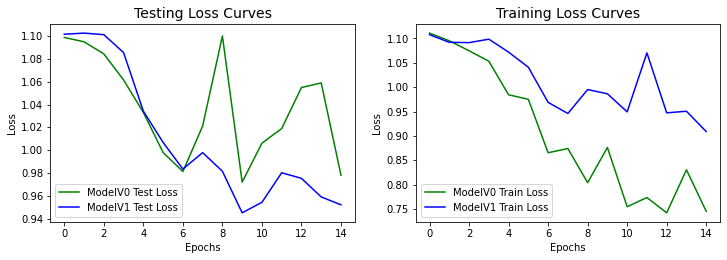

In [ ]:
def plot_models_loss_curves(model_res_0, model_res_1):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(range(model_res_0["model_epochs"]), model_res_0["model_test_loss"], c='g', label="ModelV0 Test Loss")
    plt.plot(range(model_res_1["model_epochs"]), model_res_1["model_test_loss"], c='b', label="ModelV1 Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Testing Loss Curves", fontsize=14)
    plt.legend(fontsize=10)

    plt.subplot(2, 2, 2)
    plt.plot(range(model_res_0["model_epochs"]), model_res_0["model_train_loss"], c='g', label="ModelV0 Train Loss")
    plt.plot(range(model_res_1["model_epochs"]), model_res_1["model_train_loss"], c='b', label="ModelV1 Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training Loss Curves", fontsize=14)
    plt.legend(fontsize=10)


plot_models_loss_curves(res_0, res_1)

## Making Predicitons on Unseen Data

In [ ]:
# Creating the new image path
new_image_path = dataset_path / "unseen_image.jpg"

# Downloading the image if it does not exists
if not new_image_path.is_file():
    with open(new_image_path, "wb") as f:
        req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
        print("Downloading Image...")
        f.write(req.content)
else:
    print(f"{new_image_path} already exists...")

/data/pizza_steak_sushi/unseen_image.jpg already exists...


In [ ]:
# Loading this image to Pytorch (using 'read_image()')
uint_8_image = read_image(str(new_image_path)) # Argument must be a string

print(uint_8_image.shape)
print(uint_8_image.dtype)
print(uint_8_image.device)
print(uint_8_image[0][0][:5])

torch.Size([3, 4032, 3024])
torch.uint8
cpu
tensor([154, 173, 181, 178, 183], dtype=torch.uint8)


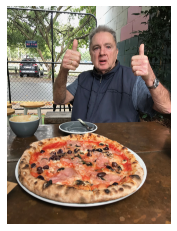

In [ ]:
# We can plot this image
plt.imshow(uint_8_image.permute(1, 2, 0))
plt.axis(False);

In [ ]:
# Converting image into a compatable format
image_tensor = uint_8_image.type(torch.float32)

# Fixing the shape of the image
resize = transforms.Resize(size=(64, 64))
image_tensor = resize(image_tensor)

print(image_tensor.shape)
print(image_tensor.dtype)
print(image_tensor[0][0][:5])

torch.Size([3, 64, 64])
torch.float32
tensor([108.8750, 241.6250, 240.2500, 244.6250, 242.0000])


In [ ]:
# Now we will changes the values of the image in the range [0, 1]
image_tensor = image_tensor / 255. # Because the values of the image lies on [0, 255]

print(image_tensor.shape)
print(image_tensor.dtype)
print(image_tensor[0][0][:5])

torch.Size([3, 64, 64])
torch.float32
tensor([0.4270, 0.9475, 0.9422, 0.9593, 0.9490])


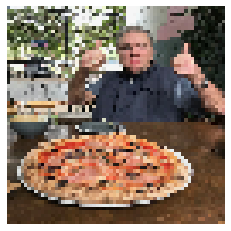

In [ ]:
# Plotting the image
plt.imshow(image_tensor.permute(1, 2, 0))
plt.axis(False);

In [ ]:
modelv1.eval()
with torch.inference_mode():
    logits = modelv1(image_tensor.unsqueeze(dim=0).to(device))

label_prob = torch.softmax(logits, dim=1).max(dim=1).values.item()
pred_label = torch.softmax(logits, dim=1).argmax(dim=1)

print(label_names[pred_label])
print(label_prob)

pizza
0.4431823492050171


To generate a prediction about an image we need:
1. To convert that image into Tensor Format
2. Change the shape to fit with the images the Model is trained on
3. Change the data type to fit with the images the Model is trained on
4. Change the range of values to fit with the images the Model is trained on
5. Make sure the image Tensor is on the same device as the Model

## Functionize the Precess

In [ ]:
def get_prediction(model, label_names, image_path, model_trained_size):
    model_dtype = next(model.parameters()).dtype
    model_device = next(model.parameters()).device

    image_tensor = read_image(str(image_path)).type(model_dtype)

    resize = transforms.Resize(size=(model_trained_size, model_trained_size))
    resized_image_tensor = resize(image_tensor)

    correct_format_tensor = resized_image_tensor / resized_image_tensor.max().item()

    model.eval()
    with torch.inference_mode():
        logits = model(correct_format_tensor.unsqueeze(dim=0).to(model_device))

    pred_label = label_names[torch.softmax(logits, dim=1).argmax(dim=1)]
    label_prob = torch.softmax(logits, dim=1).max().item() * 100

    plt.imshow(image_tensor.permute(1, 2, 0).cpu().type(torch.uint8))
    plt.title(f"Label: {pred_label} | Probability: {label_prob: .2f}%")
    plt.axis(False)

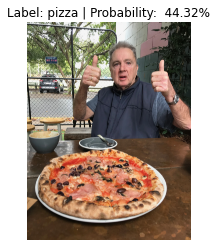

In [ ]:
get_prediction(modelv1, label_names, new_image_path, 64)

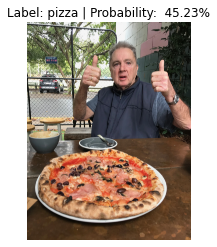

In [ ]:
get_prediction(modelv0, label_names, new_image_path, 64)